# Partition of Connected Components #

In [20]:
import sys
sys.path.append('../')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.colors
from mpl_toolkits.basemap import Basemap
import conflict
import analysis
import os
import networkx as nx
import tools
import matplotlib.backends.backend_pdf
import networkx as nx
import metis

In [2]:
# read in all data
inputFile = '../data/TrajDataV2_20120729.txt'
trajectories = pd.read_csv('%s.csv' % inputFile, index_col='flightIndex')

mindistance = 30.0
mintime = 21
delayPerConflict = 0
dthreshold = 3
maxDepartDelay = 18

name = "mindist%05.1f_mintime%03i" % (mindistance, mintime)
rawPointConflictFile = '%s.%s.rawPointConflicts.csv' % (inputFile, name)
pointConflictFile = '%s.%s.pointConflicts.csv' % (inputFile, name)       
parallelConflictFile = '%s.%s.parallelConflicts.csv' % (inputFile, name)
flights2ConflictsFile = "%s.%s.flights2Conflicts_delay%03i_thres%03i_depart%03i.h5" % (inputFile, name, delayPerConflict, dthreshold, maxDepartDelay)
reducedPointConflictFile = "%s.%s.reducedPointConflicts_delay%03i_thres%03i_depart%03i.csv" % (inputFile, name, delayPerConflict, dthreshold, maxDepartDelay)
reducedParallelConflictFile = "%s.%s.reducedParallelConflicts_delay%03i_thres%03i_depart%03i.csv" % (inputFile, name, delayPerConflict, dthreshold, maxDepartDelay)

rawPointConflicts = pd.read_csv(rawPointConflictFile, index_col='conflictIndex')
pointConflicts = pd.read_csv(pointConflictFile, index_col='conflictIndex')
parallelConflicts = pd.read_csv(parallelConflictFile, index_col='parallelConflict')
flights2Conflicts = pd.read_hdf(flights2ConflictsFile, 'flights2Conflicts')
reducedPointConflicts = pd.read_csv(reducedPointConflictFile, index_col='conflictIndex')
reducedParallelConflicts= pd.read_csv(reducedParallelConflictFile, index_col='parallelConflict')        

In [3]:
%matplotlib inline

In [21]:
conflictGraph = analysis.getConflictGraph(reducedPointConflicts, reducedParallelConflicts)

In [22]:
components = nx.connected_component_subgraphs(conflictGraph)
connectedComponents = sorted(list(components), key=lambda x: len(x.nodes()))

In [136]:
component = connectedComponents[40]

In [137]:
def plotConflictGraph(graph, node_color='lightblue', drawWeights=None):
    
    component = graph
    layout = nx.circular_layout(component)

    widthToDraw_min = 0.5
    widthToDraw_max = 3.0
    widthToDraw_mid = 0.5 * (widthToDraw_max + widthToDraw_min)
    # width = minimum absolute time difference
    minAbsTimeDiff = [l[2] for l in list(component.edges_iter(data='minAbsTimeDiffWithPartner'))]
    minMinAbsTimeDiff = np.min(minAbsTimeDiff)
    maxMinAbsTimeDiff = np.max(minAbsTimeDiff)
    midMinAbsTimeDiff = 0.5 * (minMinAbsTimeDiff + maxMinAbsTimeDiff)
    if maxMinAbsTimeDiff > minMinAbsTimeDiff:
        widthToDraw = (widthToDraw_min - widthToDraw_max) * (minAbsTimeDiff - minMinAbsTimeDiff) / (maxMinAbsTimeDiff - minMinAbsTimeDiff) + widthToDraw_max
    else:
        widthToDraw = widthToDraw_max

    nx.draw_networkx(component,
                     pos=layout,
                     node_size=600,
                     node_color=node_color,
                     font_size=10,
                     font_color='slategray',
                     linewidths=0.2,
                     edge_color='slategray',
                     with_labels=component.nodes(),
                     width=widthToDraw)
    if drawWeights is not None:
        edgeLabels = {}
        for l in list(component.edges_iter(data=drawWeights)):
            edgeLabels[(l[0], l[1])] = l[2]        
        nx.draw_networkx_edge_labels(component, layout, edge_labels=edgeLabels)
    plt.axis('off');

## Original conflict graph ##
The edge weights are the minimum absolute time difference of two trajectory points of both involved flights

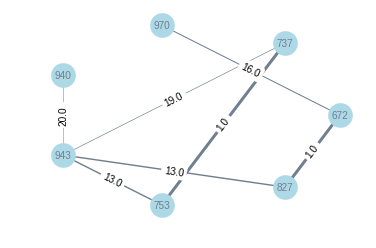

In [138]:
plotConflictGraph(component, drawWeights='minAbsTimeDiffWithPartner')

In [139]:
# get maximum minAbsTimeDiffWithPartner of all edges
maxAbsTimeDiff = 0
for i, j in component.edges():
    absTimeDiff = component.edge[i][j]['minAbsTimeDiffWithPartner']
    if absTimeDiff > maxAbsTimeDiff:
        maxAbsTimeDiff = absTimeDiff
        
# set weights for graph partitioning to maxAbsTimeDiff - absTimeDiff + 1
# in order to penalize edge cuts for small time differences
for i, j in component.edges():
    absTimeDiff = component.edge[i][j]['minAbsTimeDiffWithPartner']
    component.edge[i][j]['weight'] = int(maxAbsTimeDiff - absTimeDiff + 1)

# add graph attribute to tell metis what to use as edge weights
component.graph['edge_weight_attr'] = 'weight'

In [140]:
edgecut, partition = metis.part_graph(component, nparts=2)

In [141]:
node_color = ['lightblue' if n is 0 else 'lightgreen' for n in partition]

## Partitioned conflict graph ##
For the edge weight we use an inverted minimum absolute time difference of two trajectory points of both involved flights $\Delta t$. I.e. $\Delta t_\text{max} - \Delta_t$ so that edge cuts for small time differences are penalized

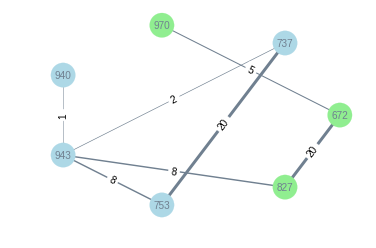

In [142]:
plotConflictGraph(component, node_color, drawWeights='weight')